# Visualize maximum SWE, mean soil water, mean ET and mean runoff per GRU
Needs: 
- Catchment shapefile with GRU delineation
- River shapefile with network delineation
- SUMMA output `scalarSWE`, `scalarTotalSoilWat`, `scalarTotalET`
- mizuRoute output `IRFroutedRunoff`

#### Special note
SUMMA and mizuRoute simulations have been preprocessed into single value statistics per model element, using auxiliary scripts in `~/summaWorkflow_public/0_tools/`. Paths to the `.nc` files that contain these statistics are not read from the `control_active.txt` file but hard-coded the sections "Simulation statistics file locations" below.

To improve visualization of large lakes, HydroLAKES lake delineations are plotted on top of the catchment GRUs and river segments. Dealing with HydroLAKES inputs is not considered within scope of the workflow and therefore requires some manual downloading and preprocessing of this data for those who wish to reproduce this step. The relevant code is easily disabled by switching the `plot_lakes = True` flag to `False`.

In [1]:
# modules
import pyproj
import matplotlib
import numpy as np
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Simulation statistics file locations

In [2]:
# SUMMA simulations
summa_output_path = Path('C:/Globus endpoint/summaWorkflow_data/domain_NorthAmerica/simulations/run1/statistics')
summa_output_name = 'run1_summa_day_stats_scalarTotalSoilWat,scalarSWE,scalarTotalET_mean,max,mean.nc'

In [3]:
# mizuRoute simulations
mizu_output_path = Path('C:/Globus endpoint/summaWorkflow_data/domain_NorthAmerica/simulations/run1/statistics')
mizu_output_name = 'run1_mizuRoute_mean_KWT_IRF.nc'

#### Plot lakes?

In [4]:
plot_lakes = True

In [5]:
# lakes shapefile
lake_path = Path('C:/Globus endpoint/HydroLAKES/HydroLAKES_polys_v10_shp')
lake_name = 'HydroLAKES_polys_v10_subset_NA.shp'

#### Control file handling

In [6]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [7]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [8]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [9]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [29]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'max_swe_AND_mean_sm_AND_mean_et_AND_mean_q_FOR_NorthAmerica_v4_compressed.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Catchment shapefile location and variable names

In [11]:
# HM catchment shapefile path & name
hm_catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
hm_catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

# Specify default path if needed
if hm_catchment_path == 'default':
    hm_catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    hm_catchment_path = Path(hm_catchment_path) # make sure a user-specified path is a Path()

In [11]:
# Find the GRU and HRU identifiers
hm_hruid = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### River network shapefile location and variable names

In [13]:
# River network path & name
river_network_path = read_from_control(controlFolder/controlFile,'river_network_shp_path')
river_network_name = read_from_control(controlFolder/controlFile,'river_network_shp_name')

# Specify default path if needed
if river_network_path == 'default':
    river_network_path = make_default_path('shapefiles/river_network') # outputs a Path()
else:
    river_network_path = Path(river_network_path) # make sure a user-specified path is a Path()

In [12]:
# Find the segment ID
seg_id = read_from_control(controlFolder/controlFile,'river_network_shp_segid')

#### Load all shapefiles and project to Albers Conformal Conic

In [15]:
# catchment shapefile
bas = gpd.read_file(hm_catchment_path/hm_catchment_name)

In [16]:
# river network shapefile
riv = gpd.read_file(river_network_path/river_network_name)

In [17]:
# lakes shapefile
if plot_lakes:
    lakes = gpd.read_file(lake_path/lake_name)

In [18]:
# Set the target CRS
acc = 'ESRI:102008'

In [19]:
# Reproject
bas_albers = bas.to_crs(acc)
riv_albers = riv.to_crs(acc)
lak_albers = lakes.to_crs(acc)

In [20]:
# Print the median basin size for curiousity
print('median area = {} m^2'.format(bas['HRU_area'].median() / 10**6))
print('mean area   = {} m^2'.format(bas['HRU_area'].mean() / 10**6))

median area = 33.06877343600296 m^2
mean area   = 40.19396140285971 m^2


In [13]:
# Get the albers shapes
main = Path('C:/Globus endpoint/summaWorkflow_data/domain_NorthAmerica/shapefiles/albers_projection')
lak_albers = gpd.read_file(main/'lakes.shp')

In [14]:
riv_albers = gpd.read_file(main/'river.shp')

In [15]:
bas_albers = gpd.read_file(main/'basin.shp')

### Pre-processing
#### Map SUMMA sims to catchment shapes

In [16]:
# Get the aggregated statistics of SUMMA simulations
summa = xr.open_dataset(summa_output_path/summa_output_name)

In [17]:
# Specify variables of interest
plot_vars = ['scalarSWE','scalarTotalET','scalarTotalSoilWat']

In [18]:
# Match the accummulated values to the correct HRU IDs in the shapefile
hru_ids_shp = bas_albers[hm_hruid].astype(int) # hru order in shapefile
for plot_var in plot_vars:
    bas_albers[plot_var] = summa[plot_var].sel(hru=hru_ids_shp.values)

#### Map mizuRoute sims to river shapes

In [19]:
# Get the aggregated statistics of mizuRoute simulations
mizu = xr.open_dataset(mizu_output_path/mizu_output_name)

In [20]:
# Specify variables of interest
mizu_vars = ['IRFroutedRunoff','KWTroutedRunoff']

In [21]:
# polygon order in the simulation file
seg_ids_sim = mizu['reachID'].values

In [22]:
# ensure that the shapefile is in the same order as the sims
riv_albers = riv_albers.set_index(riv_albers[seg_id].astype('int'))
riv_albers = riv_albers.reindex(seg_ids_sim)

In [23]:
# Match the accummulated values to the correct HRU IDs in the shapefile
seg_ids_riv = riv_albers.index.values # hru order in shapefile
for mizu_var in mizu_vars:
    riv_albers[mizu_var] = mizu[mizu_var].sel(seg=np.where(mizu['reachID'].values == seg_ids_riv)[0]).values[0]

In [24]:
# Add a linewidth column for the river network
riv_albers['lineWidth'] = np.maximum(np.log10(riv_albers['IRFroutedRunoff'] ),0)

#### Select lakes of a certain size for plotting

In [25]:
if plot_lakes:
    minSize = 1000 # km2
    in_domain = (lak_albers['Country'] == 'Canada') | \
                (lak_albers['Country'] == 'United States of America') | \
                (lak_albers['Country'] == 'Mexico')
    out_domain = (lak_albers['Pour_long'] > -80) & (lak_albers['Pour_lat'] > 65) # Exclude Baffin Island
    large_lakes_albers = lak_albers.loc[(lak_albers['Lake_area'] > minSize) & in_domain & (~out_domain) ]

In [26]:
# Set the lake color
if plot_lakes:
    lake_col = (8/255,81/255,156/255)

### Figure

In [31]:
# Set the font size: we need this to be huge so we can also make our plotting area huge, to avoid a gnarly plotting bug
if 'compressed' in fig_name:
    plt.rcParams.update({'font.size': 25})
else:
    plt.rcParams.update({'font.size': 100})

In [28]:
# Flip the evaporation values so that they become positive
bas_albers['plot_ET'] = bas_albers['scalarTotalET'] * -1
bas_albers['plot_ET'] = bas_albers['plot_ET'].where(bas_albers['scalarTotalET'] != -9999, np.nan)

C:\Users\wmk934\AppData\Local\Temp\1\ipykernel_9736\2855447990.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


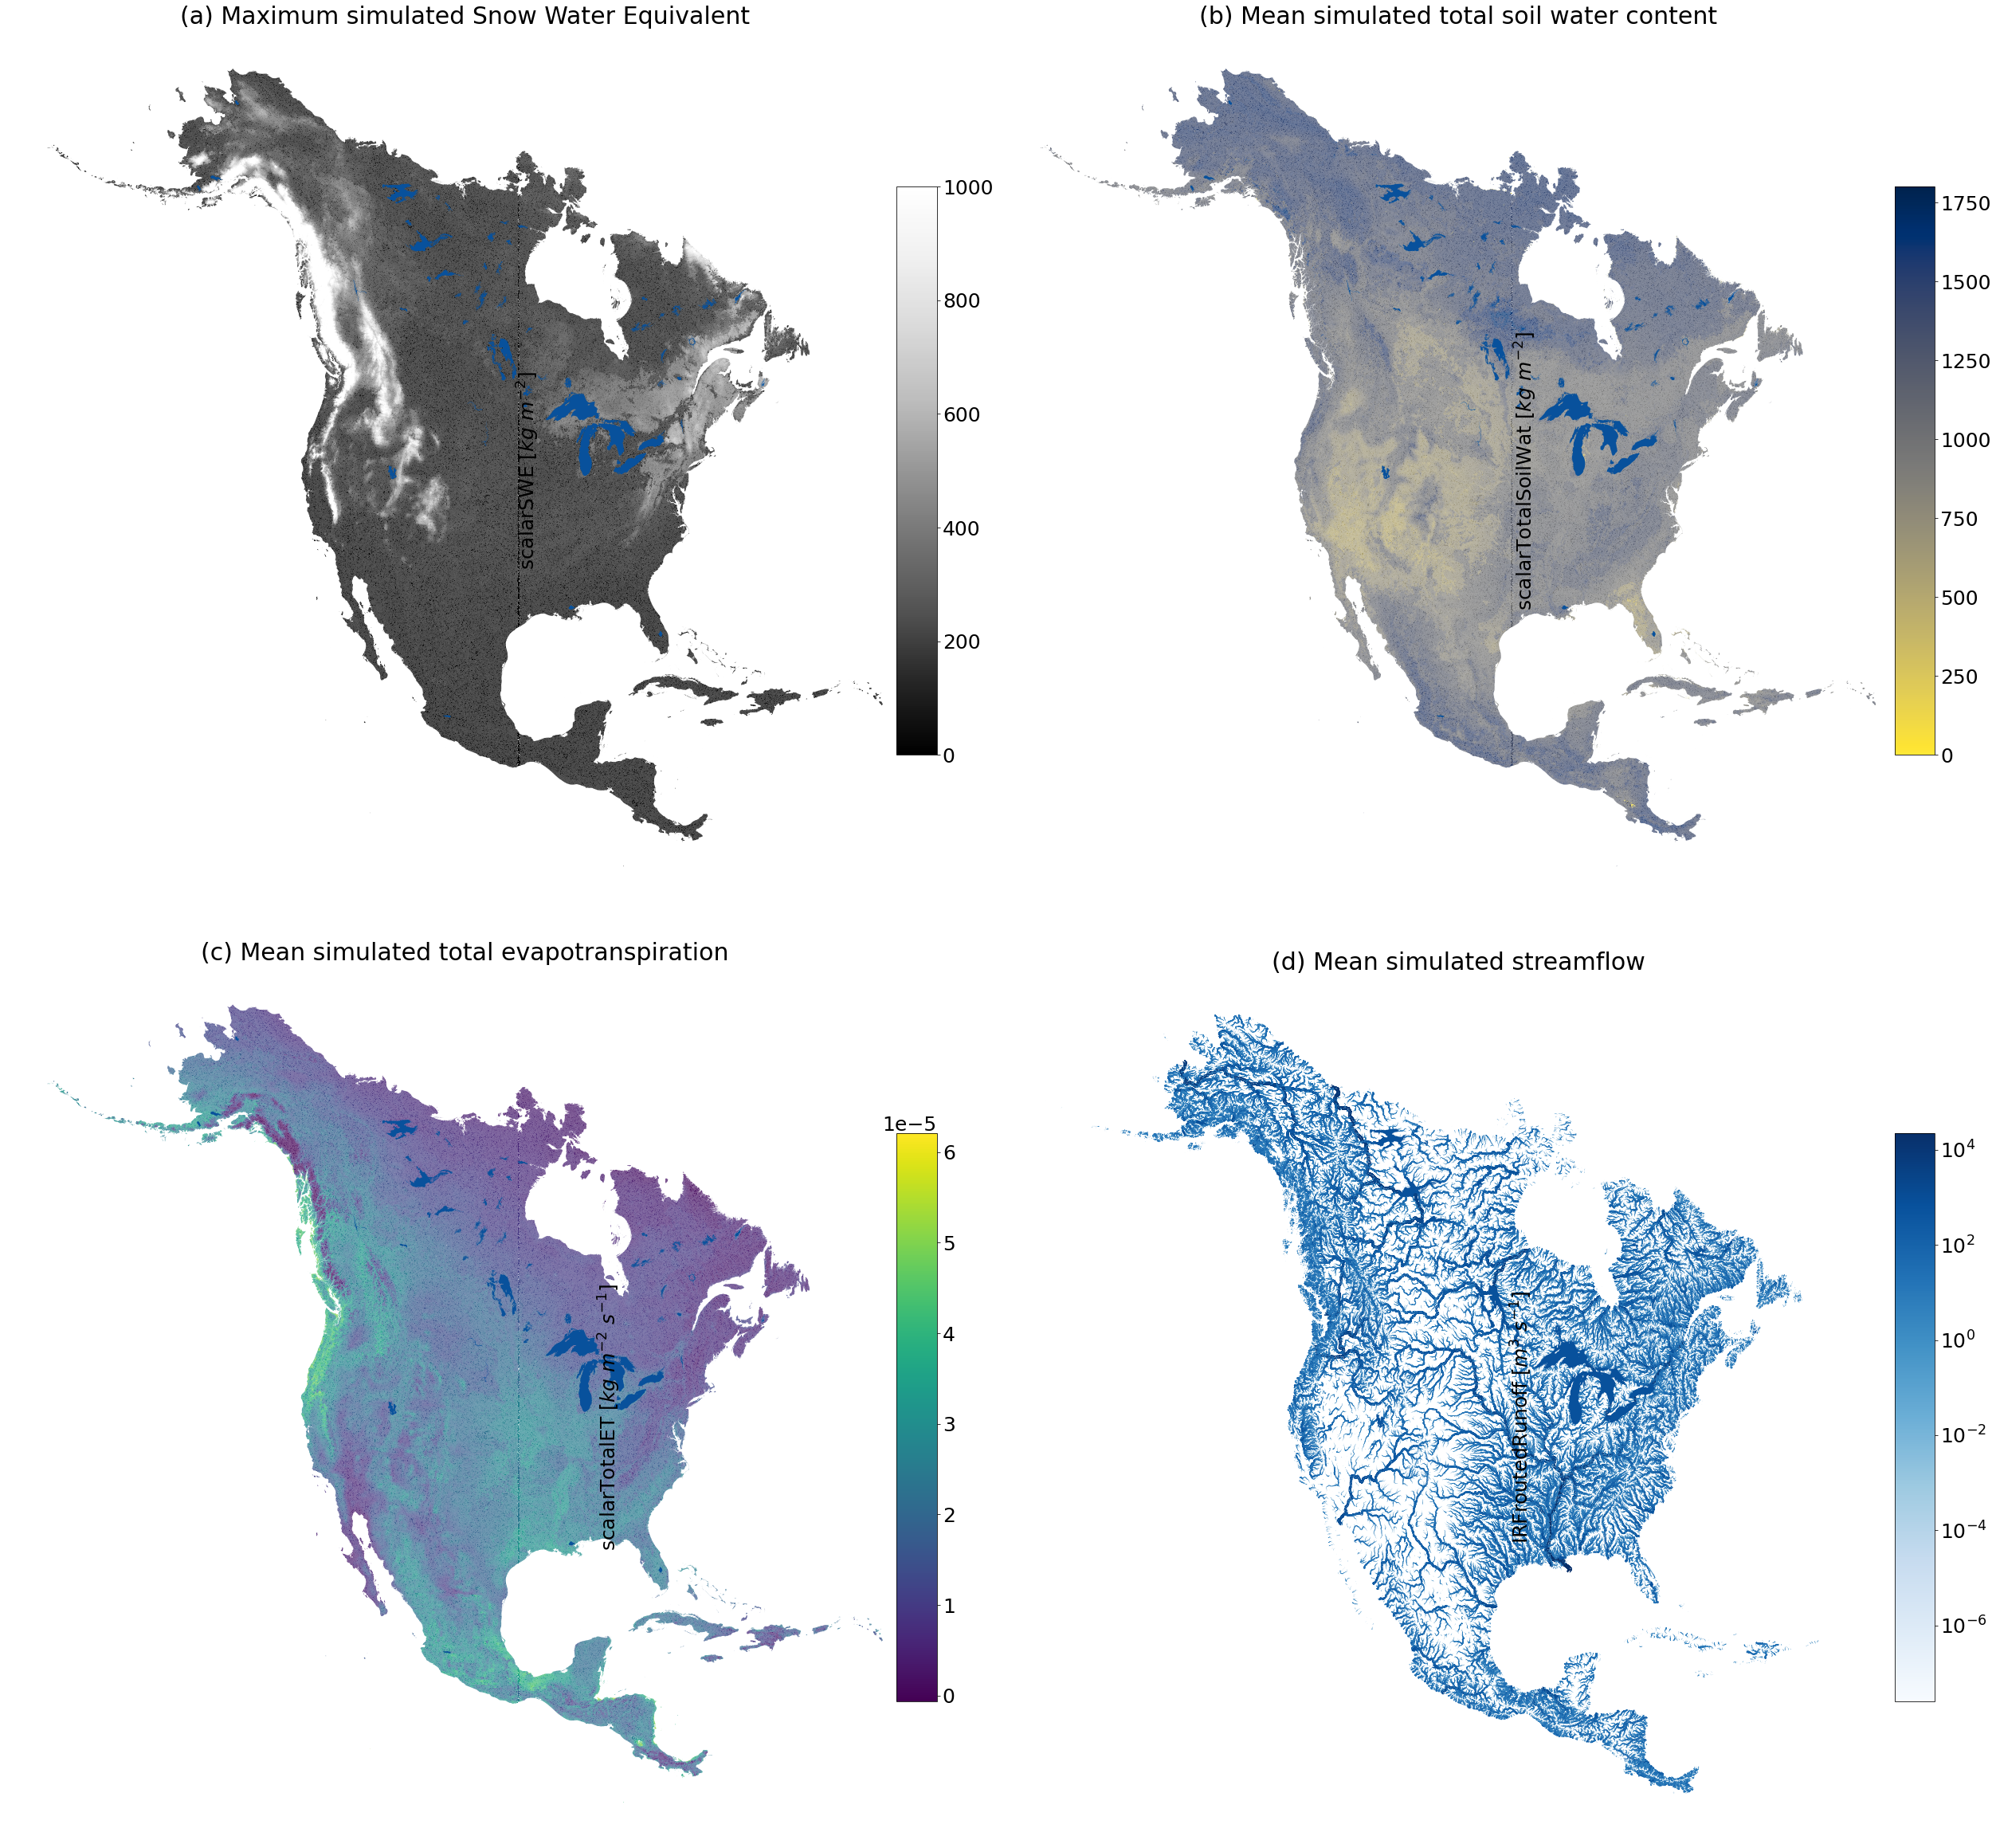

In [32]:
if 'compressed' in fig_name:
    fig,axs = plt.subplots(2,2,figsize=(35,33))
else:
    fig,axs = plt.subplots(2,2,figsize=(140,133))

# colorbar axes
cax1 = fig.add_axes([0.473,0.60,0.02,0.3])
cax2 = fig.add_axes([0.97 ,0.60,0.02,0.3])
cax3 = fig.add_axes([0.473,0.10,0.02,0.3])
cax4 = fig.add_axes([0.97 ,0.10,0.02,0.3])

plt.tight_layout()

# add maps
bas_albers.plot(ax=axs[0,0], column='scalarSWE', edgecolor='none', legend=True, vmin=0, vmax=1000, \
                cmap='Greys_r', cax=cax1, zorder=0)
axs[0,0].set_title('(a) Maximum simulated Snow Water Equivalent')
axs[0,0].axis('off')
cax1.set_ylabel('scalarSWE $[kg~m^{-2}]$',labelpad=-600)

# SM
bas_albers.plot(ax=axs[0,1], column='scalarTotalSoilWat', edgecolor='none', legend=True, vmin=0, \
                cmap='cividis_r', cax=cax2, zorder=0)
axs[0,1].set_title('(b) Mean simulated total soil water content')
axs[0,1].axis('off')
cax2.set_ylabel('scalarTotalSoilWat $[kg~m^{-2}]$',labelpad=-600)

# ET
bas_albers.plot(ax=axs[1,0], column='plot_ET', edgecolor='none', legend=True,\
                cmap='viridis', cax=cax3, zorder=0)
axs[1,0].set_title('(c) Mean simulated total evapotranspiration')
axs[1,0].axis('off')
cax3.set_ylabel('scalarTotalET $[kg~m^{-2}~s^{-1}]$',labelpad=-450)

# Flow
var = 'IRFroutedRunoff'
norm = matplotlib.colors.LogNorm(vmin=riv_albers[var].min(), vmax=riv_albers[var].max())
riv_albers.plot(ax=axs[1,1],column=var, linewidth=riv_albers['lineWidth'], \
                                    cmap='Blues', legend=True, cax=cax4, norm=norm, zorder=0)
axs[1,1].set_title('(d) Mean simulated streamflow')
axs[1,1].axis('off')
cax4.set_ylabel('IRFroutedRunoff $[m^3~s^{-1}]$',labelpad=-600)

# lakes
if plot_lakes:
    large_lakes_albers.plot(ax=axs[0,0], color=lake_col, zorder=1)
    large_lakes_albers.plot(ax=axs[0,1], color=lake_col, zorder=1)
    large_lakes_albers.plot(ax=axs[1,0], color=lake_col, zorder=1)
    large_lakes_albers.plot(ax=axs[1,1], color=lake_col, zorder=1)

# Save 
plt.savefig(fig_path/fig_name, bbox_inches='tight', transparent=True)